# Bayesian Regularization of Deep Neural Networks 
> Automatic relevance determination via feature-specific Gaussian priors on input weights.

- toc: true 
- badges: true
- comments: true
- categories: [bayesian, deep learning, feature selection]




When fitting flexible models to noisy financial data we need to take special care to avoid overfitting. In addition to bad generalization and thus higher test-set loss, overfit models also increase transaction costs of trading algorithms based on them. Frequent changes in the mean return prediction lead to frequent changes in optimal portfolio weights and thus overtrading. Here we focus on the following two kinds of regularization:
1. promoting smoothness.
2. promoting sparsity in the input weights (or automatic feature selection).


In [1]:
# hide
! pip install pyro-ppl 
! pip install pymc3 --upgrade
! pip install arviz
! pip install numpyro

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.9.3)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2


# Noisy data with lots of irrelevant features

Let's simulate some data. 
- 500 training observations
- 1 relevant feature
- 50 irrelevant features
- observation noise
- non-linear

These data will be predicted via 3 different models. First, a deep ensemble is fitted with $\ell_1$ and $\ell_2$ regularization. Then a Bayesian neural network with Gaussian priors is tried. Finally, a Bayesian neural network with Gaussian priors and automatic relevance determination is shown to substatially improve generalization. This is achieved via Inverse-Gamma priors on the feature-specific variance of the Gaussian weight priors.

In [3]:
n = 1000
X = np.sort(np.random.normal(0,1,n))
Y = 1*X**2 + 1*np.random.normal(0,1, n)

In [4]:
train_indexes = np.sort(np.random.choice(np.arange(n), n//2))
k = 50
irrelevant_features = np.random.normal(0,1,k*n).reshape(n,k)
X = X[:,None]
print(X.shape, irrelevant_features.shape)
X = np.concatenate((X,irrelevant_features),1)
X_train, Y_train = X[train_indexes], Y[train_indexes, None]
X_test, Y_test = X[np.sort(~train_indexes)], Y[np.sort(~train_indexes), None]
X_train.shape, Y_train.shape

(1000, 1) (1000, 50)


((500, 51), (500, 1))

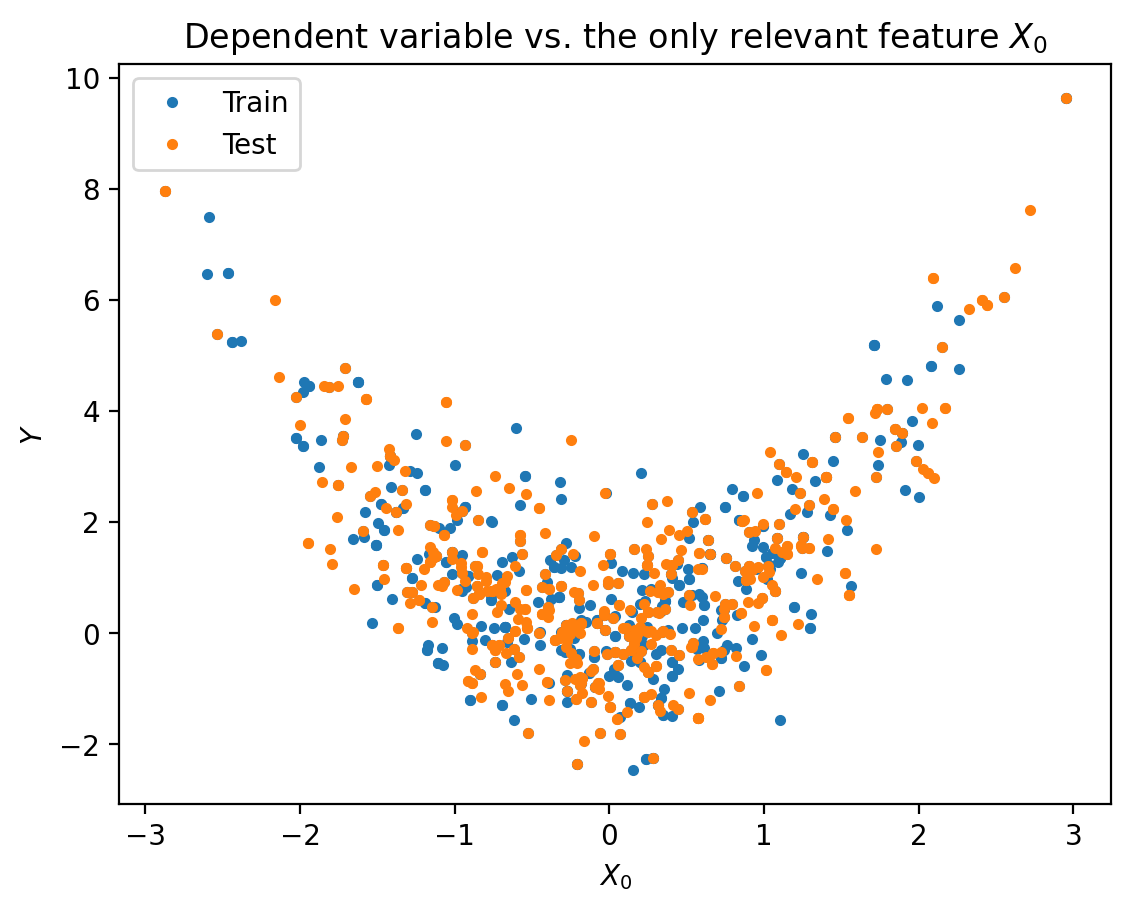

In [5]:
plt.plot(X_train[:,0], Y_train.squeeze(), '.', label='Train')
plt.plot(X_test[:,0], Y_test.squeeze(), '.', label='Test')
plt.legend()
plt.xlabel("$X_0$")
plt.ylabel("$Y$")
plt.title("Dependent variable vs. the only relevant feature $X_0$")
plt.show();

# Deep Enembles

We fit multiple neural networks with $\ell_1$ and $\ell_2$ penalties. The drawback of this approach is that the penalty parameter has to chosen ad hoc and selection must be based on validation set performance. Generally, the parameter needs to be adjusted to fit a complex vs. simple model. 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
from collections import OrderedDict 


def fit_model(model, epochs, X, Y, X_valid, Y_valid):
    optimizer = optim.Adam(model.parameters(), weight_decay=1e-3, lr=1e-3)
    for epoch in (range(epochs)):
        # trainig mode
        model = model.train()
        model.zero_grad()
        Y_hat = model(X)
        loss = criterion(Y_hat, Y)

         # promote sparsity on input layer
        l1 = torch.sqrt(model.lin1.weight.abs().sum() 
                        + model.lin1.bias.abs().sum())
        factor = 1e-3
        loss += factor * l1

        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 ==0:
          with torch.no_grad():
            model.eval()
            Y_hat = model(X_valid)
            # print(f'Epoch: {epoch+1} \t Train loss: {loss} \t Valid loss: {criterion(Y_hat, Y_valid)}')

def predict(model, X):
    with torch.no_grad():
        model.eval()
        Y_hat = model(X)
    return Y_hat



In [7]:
print("GPU available:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


GPU available: False


In [8]:
N = 10
n_neurons = 5
dropout = 0.
epochs = 1000
criterion = nn.MSELoss()

# Train set
X_train_tensor = torch.tensor(X_train).float().to(device)
Y_train_tensor = torch.tensor(Y_train).float().to(device)

# Validation set
X_test_tensor = torch.tensor(X_test).float().to(device)
Y_test_tensor = torch.tensor(Y_test).float().to(device)

n_features = X_train_tensor.shape[1]
models = [nn.Sequential(OrderedDict([
          ('lin1', nn.Linear(n_features, n_neurons)),
          ('bn1',nn.BatchNorm1d(n_neurons)),
          ('relu1', nn.ReLU()),
          ('lin2', nn.Linear(n_neurons, n_neurons)),
          ('bn2',nn.BatchNorm1d(n_neurons)),
          ('relu2', nn.ReLU()),
          ('lin3', nn.Linear(n_neurons, n_neurons)),
          ('bn3',nn.BatchNorm1d(n_neurons)),
          ('relu3', nn.ReLU()),
          ('lin4', nn.Linear(n_neurons, n_neurons)),
          ('bn4',nn.BatchNorm1d(n_neurons)),
          ('relu4', nn.ReLU()),
          ('out', nn.Linear(n_neurons, 1)),
        ])) for i in range(N)]

for i, model in tqdm(enumerate(models)):
  model.to(device)
  fit_model(model, epochs, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)

10it [00:33,  3.35s/it]


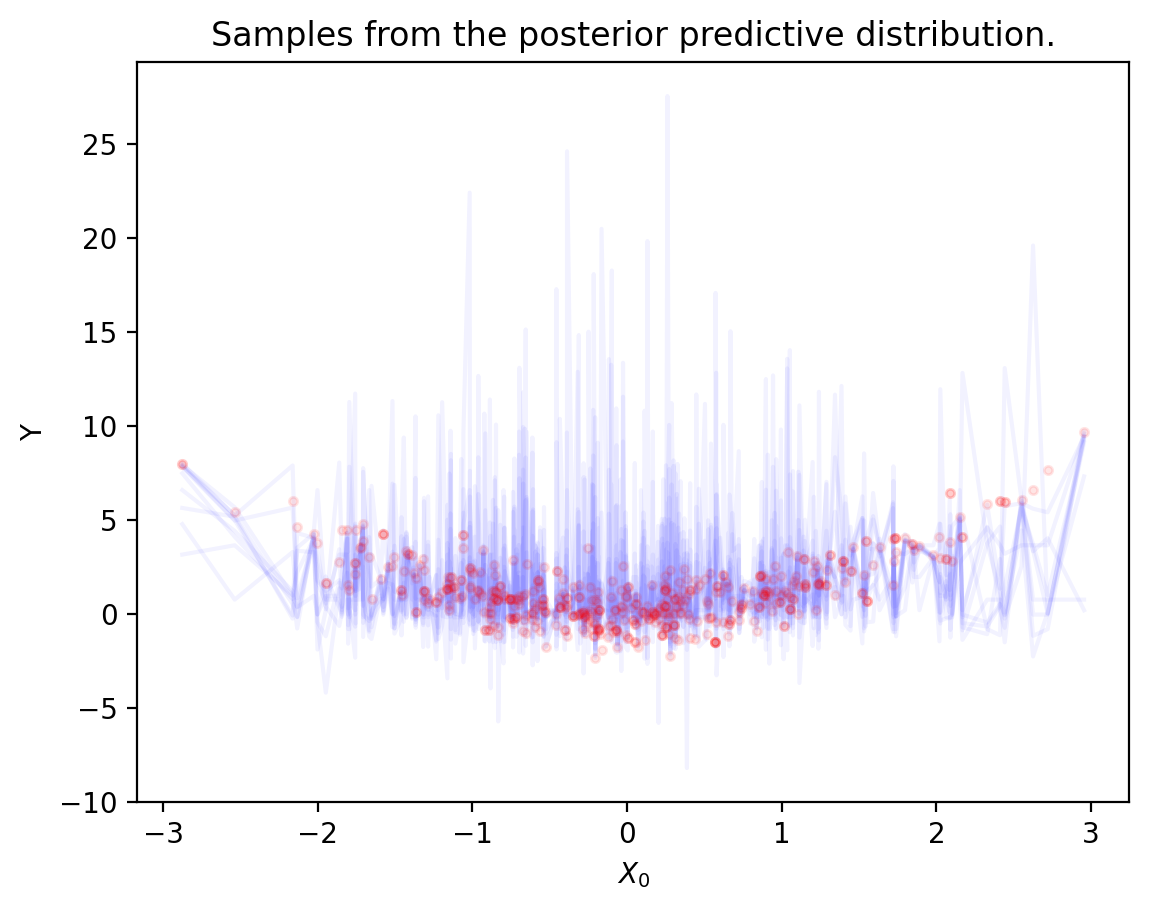

In [9]:
y_hat_list = [] 
for model in models:
  y_hat_list.append(predict(model, X_test_tensor).cpu().numpy().squeeze())

df = pd.DataFrame(np.array(y_hat_list).T, index=X_test[:,0])
df.sort_index(inplace=True)
df.plot(legend=False, alpha=0.05, c='b')
plt.plot(X_test[:,0], Y_test.squeeze(), '.', alpha=0.1, c='r')
plt.xlabel("$X_0$")
plt.ylabel("Y")
plt.title("Samples from the posterior predictive distribution.")
plt.show()

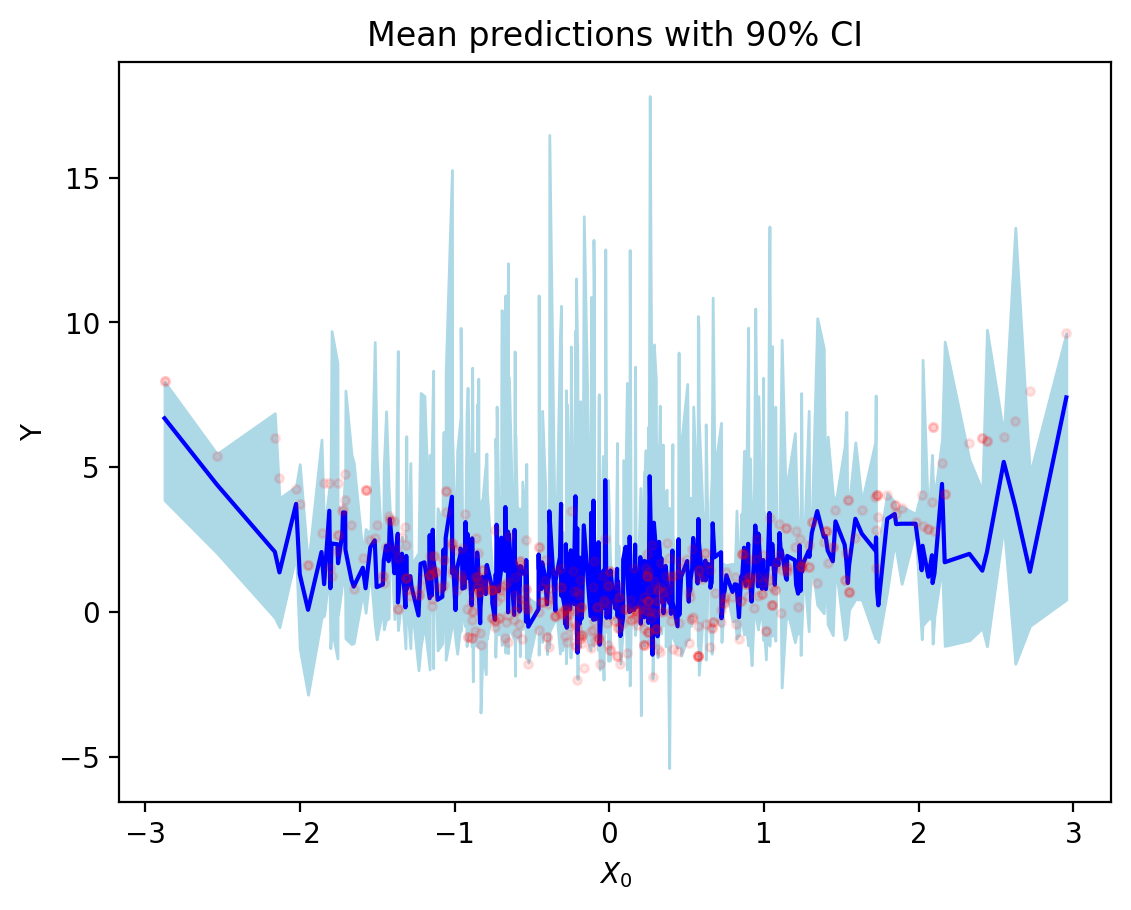

In [10]:
percentiles = df.quantile([0.05, 0.95], axis=1).T

df.mean(1).plot(alpha=1, c='b')
plt.plot(X_test[:,0], Y_test.squeeze(), '.', alpha=0.1, c='r')
plt.fill_between(X_test[:,0], percentiles.iloc[:,0], percentiles.iloc[:,1], color='lightblue')
plt.xlabel("$X_0$")
plt.ylabel("Y")
plt.title("Mean predictions with 90% CI");

In [11]:
print("MSE:", ((df.mean(1) - Y_test.squeeze())**2).mean())

MSE: 2.3996687514148483


The test loss is bad. The mean prediction is very volatile. This will lead to inaccurate predictions and high transaction costs.

# Numpyro



In [12]:
import os
from functools import partial
import torch
import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.5.0')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)



In [13]:
"""
Bayesian Neural Network
=======================

Adapted from https://github.com/pyro-ppl/numpyro/blob/master/examples/bnn.py
"""

import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS


args = pd.Series({'num_samples':3000, 'num_warmup':2000, 'num_chains':1,
                  'num_hidden':5,'device':'cpu'})

numpyro.set_platform(platform=args.device)
if args.device == 'cpu':
  numpyro.set_host_device_count(args.num_chains)

# # the non-linearity we use in our neural network
def nonlin(x):
    return jnp.maximum(0, x)


# helper function for HMC inference
def run_inference(model, args, rng_key, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, args.num_warmup, args.num_samples, num_chains=args.num_chains,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y, D_H)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# helper function for prediction
def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace['Y']['value']


In [14]:
def model(X, Y, D_H):

    D_X, D_Y = X.shape[1], 1

    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))  # D_X D_H
    b1 = numpyro.sample("b1", dist.Normal(jnp.zeros((D_H)), jnp.ones((D_H))))
    z1 = nonlin(jnp.matmul(X, w1) + b1)

    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    b2 = numpyro.sample("b2", dist.Normal(jnp.zeros((D_H)), jnp.ones((D_H))))
    z2 = nonlin(jnp.matmul(z1, w2) + b2) 

    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    b3 = numpyro.sample("b3", dist.Normal(jnp.zeros((D_H)), jnp.ones((D_H))))
    z3 = nonlin(jnp.matmul(z2, w3) + b3)

    w4 = numpyro.sample("w4", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    b4 = numpyro.sample("b4", dist.Normal(jnp.zeros((D_H)), jnp.ones((D_H))))
    z4 = nonlin(jnp.matmul(z3, w4) + b4) 

    w5 = numpyro.sample("w5", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))  # D_H D_Y
    b5 = numpyro.sample("b5", dist.Normal(jnp.zeros((D_Y)), jnp.ones((D_Y))))
    z5 = jnp.matmul(z4, w5) + b5 

    # we put a prior on the observation noise
    # here we could trivially account for heteroskedasticity.
    prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    # observe data
    numpyro.sample("Y", dist.Normal(z5, sigma_obs), obs=Y)

In [15]:
N, D_H = len(X_train), args.num_hidden

# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X_train, Y_train, D_H)

sample: 100%|██████████| 5000/5000 [20:12<00:00,  4.12it/s, 1023 steps of size 5.85e-04. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]      0.23      0.11      0.22      0.05      0.40     40.75      1.00
     b1[1]     -0.39      0.12     -0.40     -0.55     -0.15     39.25      1.03
     b1[2]      0.24      0.11      0.24      0.06      0.43     34.90      1.01
     b1[3]      0.87      0.13      0.87      0.64      1.06     16.72      1.12
     b1[4]     -2.11      0.13     -2.12     -2.33     -1.89      8.93      1.41
     b2[0]     -2.16      0.34     -2.14     -2.76     -1.64     15.21      1.06
     b2[1]      0.32      0.11      0.29      0.17      0.50      5.16      1.41
     b2[2]     -0.64      0.23     -0.60     -1.00     -0.28     16.30      1.05
     b2[3]     -0.03      0.11     -0.03     -0.22      0.13     46.79      1.02
     b2[4]      0.94      0.28      0.87      0.52      1.33      8.61      1.16
     b3[0]     -0.48      0.18     -0.47     -0.76     -0.17     27.56      1.00
     b3[1]      0.88      0

In [16]:
# predict Y (test) at inputs X
vmap_args = (samples, random.split(rng_key_predict, args.num_samples * args.num_chains))
predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_test, D_H))(*vmap_args)
predictions = predictions[..., 0]

# compute mean prediction and confidence interval around median
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

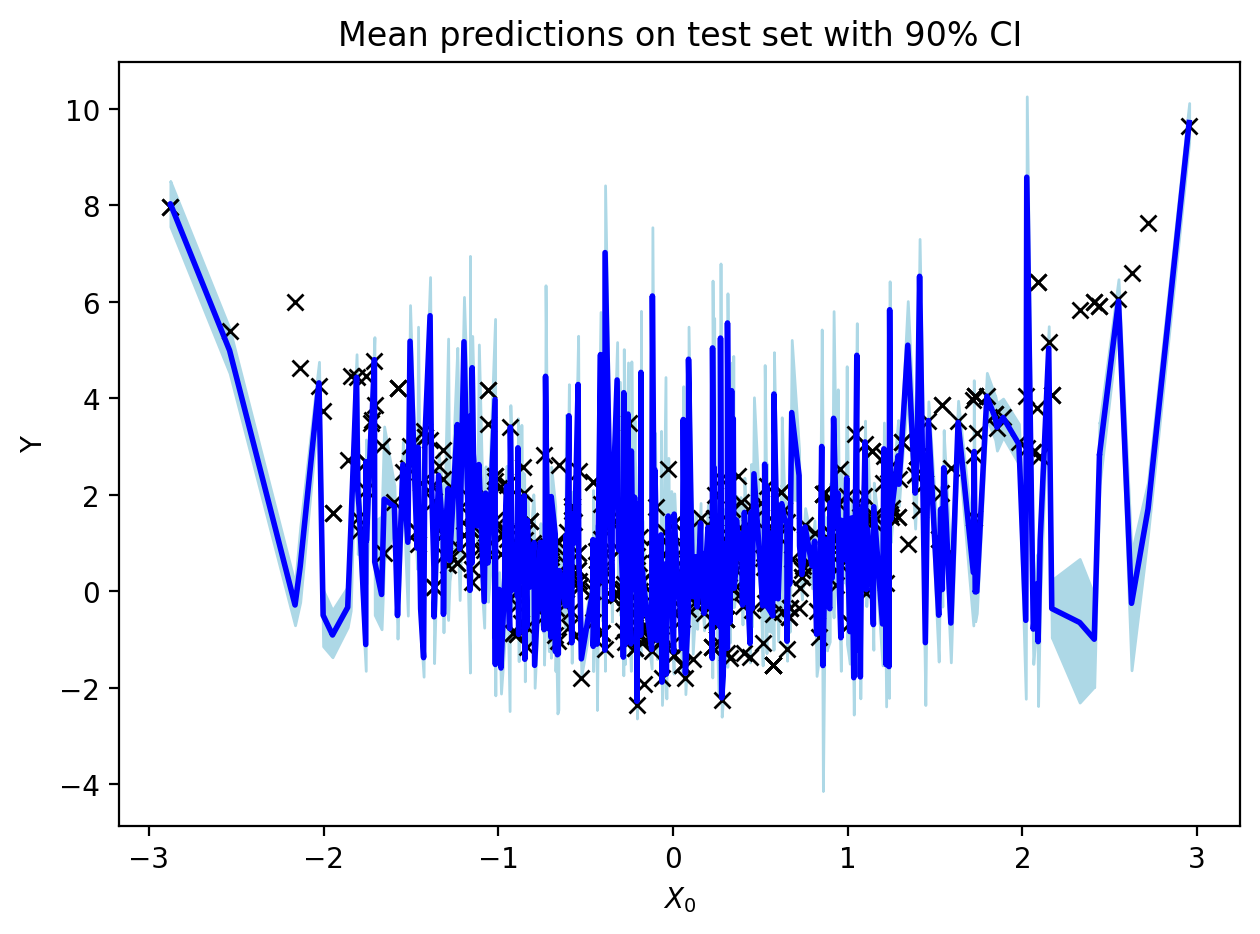

In [17]:
fig, ax = plt.subplots(1, 1)
# plot training data
ax.plot(X_test[:, 0], Y_test[:, 0], 'kx')
# plot 90% credible interval of predictions
ax.fill_between(X_test[:,0], percentiles[0, :], percentiles[1, :], color='lightblue')
# plot mean prediction
ax.plot(X_test[:,0], mean_prediction, 'blue', ls='solid', lw=2.0)
ax.set(xlabel="$X_0$", ylabel="Y", title="Mean predictions on test set with 90% CI")
plt.tight_layout()
plt.show()


In [18]:
print(f"MSE: {np.mean((mean_prediction - Y_test.squeeze())**2)}")

MSE: 4.170048236846924


The test loss is again very bad. Irrelevant features drown the signal. To improve the model we will use automatic relevance determination.

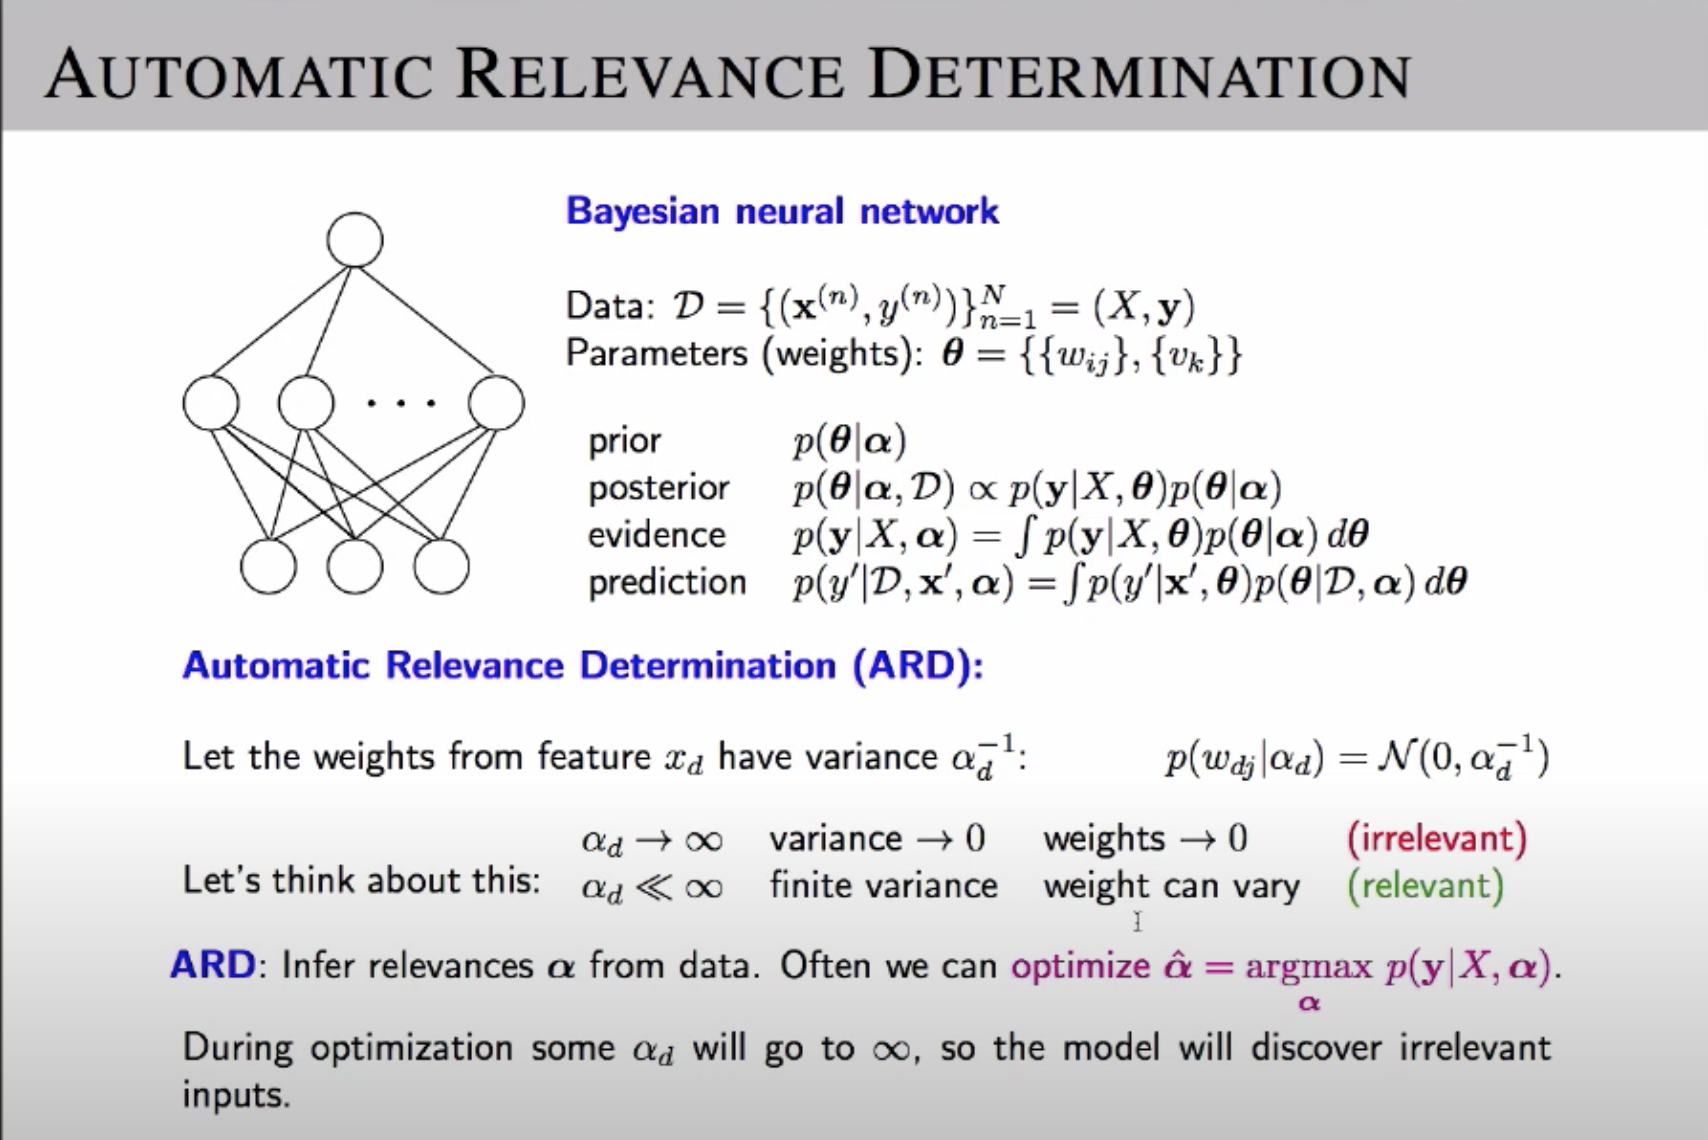

Source: Zoubin Ghahramani (University of Cambridge)
Bayesian Deep Learning Workshop "History of Bayesian Neural Networks (Keynote talk)" https://www.youtube.com/watch?v=FD8l2vPU5FY&feature=youtu.be

A Gaussian prior on the weights promotes smoothness and letting their individual variance parameters go to zero promotes sparsity. 

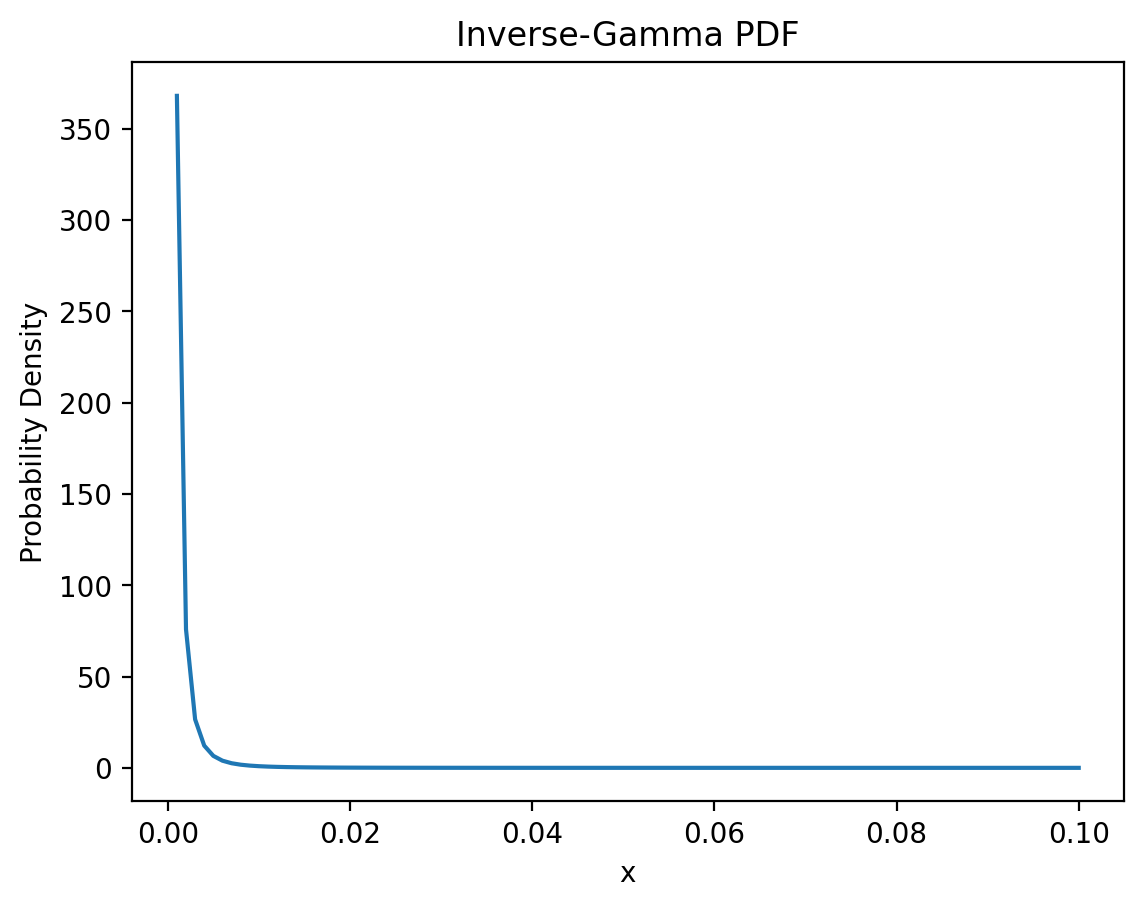

In [19]:
x = jnp.linspace(0, 0.1, 101)
px = jnp.exp(dist.InverseGamma(2, 0.001).log_prob(x))
plt.plot(x, px)
plt.gca().set(title="Inverse-Gamma PDF", xlabel="x", ylabel="Probability Density")
plt.show()

In [20]:

def model(X, Y, D_H):

    D_X, D_Y = X.shape[1], 1

    s1 = numpyro.sample("s1", dist.InverseGamma(2*jnp.ones((D_X)), 0.001*jnp.ones((D_X))))
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.repeat(s1[:,None],D_H, axis=1)))
    b1 = numpyro.sample("b1", dist.Normal(jnp.zeros((D_H)), jnp.ones((D_H))))
    z1 = nonlin(jnp.matmul(X, w1) + b1)

    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    b2 = numpyro.sample("b2", dist.Normal(jnp.zeros((D_H)), jnp.ones((D_H))))
    z2 = nonlin(jnp.matmul(z1, w2) + b2) 

    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    b3 = numpyro.sample("b3", dist.Normal(jnp.zeros((D_H)), jnp.ones((D_H))))
    z3 = nonlin(jnp.matmul(z2, w3) + b3)

    w4 = numpyro.sample("w4", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    b4 = numpyro.sample("b4", dist.Normal(jnp.zeros((D_H)), jnp.ones((D_H))))
    z4 = nonlin(jnp.matmul(z3, w4) + b4) 

    w5 = numpyro.sample("w5", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))  # D_H D_Y
    b5 = numpyro.sample("b5", dist.Normal(jnp.zeros((D_Y)), jnp.ones((D_Y))))
    z5 = jnp.matmul(z4, w5) + b5 

    # we put a prior on the observation noise
    # here we could trivially account for heteroskedasticity.
    prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    # observe data
    numpyro.sample("Y", dist.Normal(z5, sigma_obs), obs=Y)

In [21]:
N, D_H = len(X_train), args.num_hidden

# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X_train, Y_train, D_H)


sample: 100%|██████████| 5000/5000 [21:04<00:00,  3.95it/s, 1023 steps of size 1.03e-03. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]      0.06      0.76      0.09     -1.41      1.16     68.72      1.02
     b1[1]      0.22      0.84      0.20     -1.36      1.52     35.59      1.00
     b1[2]      0.25      0.79      0.20     -1.22      1.49     79.47      1.00
     b1[3]      0.17      0.74      0.09     -1.06      1.45     31.45      1.02
     b1[4]     -0.09      0.85     -0.06     -1.37      1.44     43.68      1.02
     b2[0]      0.04      1.02      0.02     -1.55      1.72    133.32      1.00
     b2[1]     -0.01      0.94     -0.01     -1.52      1.49    187.03      1.01
     b2[2]      0.23      0.92      0.25     -1.34      1.64    132.35      1.01
     b2[3]      0.10      0.91      0.12     -1.38      1.58    127.00      1.00
     b2[4]      0.00      0.97      0.01     -1.58      1.65     96.67      1.00
     b3[0]     -0.09      0.98     -0.08     -1.74      1.50    127.11      1.00
     b3[1]     -0.03      1

Notice how only ``s1[0]`` is significantly different from zero, meaning that only feature 0 is selected.  

In [22]:
# predict Y (test) at inputs X
vmap_args = (samples, random.split(rng_key_predict, args.num_samples * args.num_chains))
predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_test, D_H))(*vmap_args)
predictions = predictions[..., 0]

# compute mean prediction and credible interval around median
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

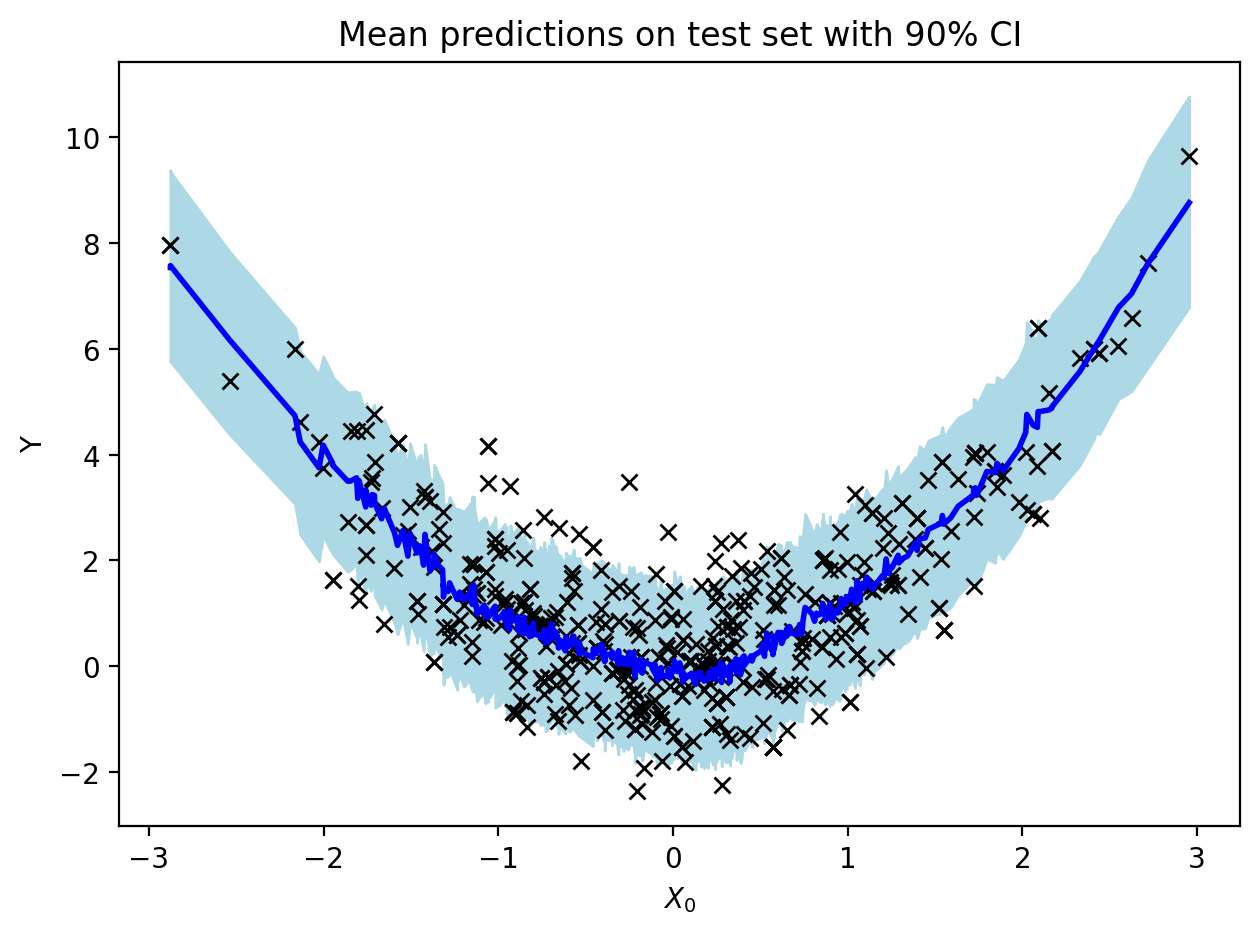

In [23]:
fig, ax = plt.subplots(1, 1)
# plot training data
ax.plot(X_test[:, 0], Y_test[:, 0], 'kx')
# plot 90% credible level of predictions
ax.fill_between(X_test[:,0], percentiles[0, :], percentiles[1, :], color='lightblue')
# plot mean prediction
ax.plot(X_test[:,0], mean_prediction, 'blue', ls='solid', lw=2.0)
ax.set(xlabel="$X_0$", ylabel="Y", title="Mean predictions on test set with 90% CI")
plt.tight_layout()
plt.show()


In [24]:
print(f"MSE: {np.mean((mean_prediction - Y_test.squeeze())**2)}")

MSE: 1.0187569856643677


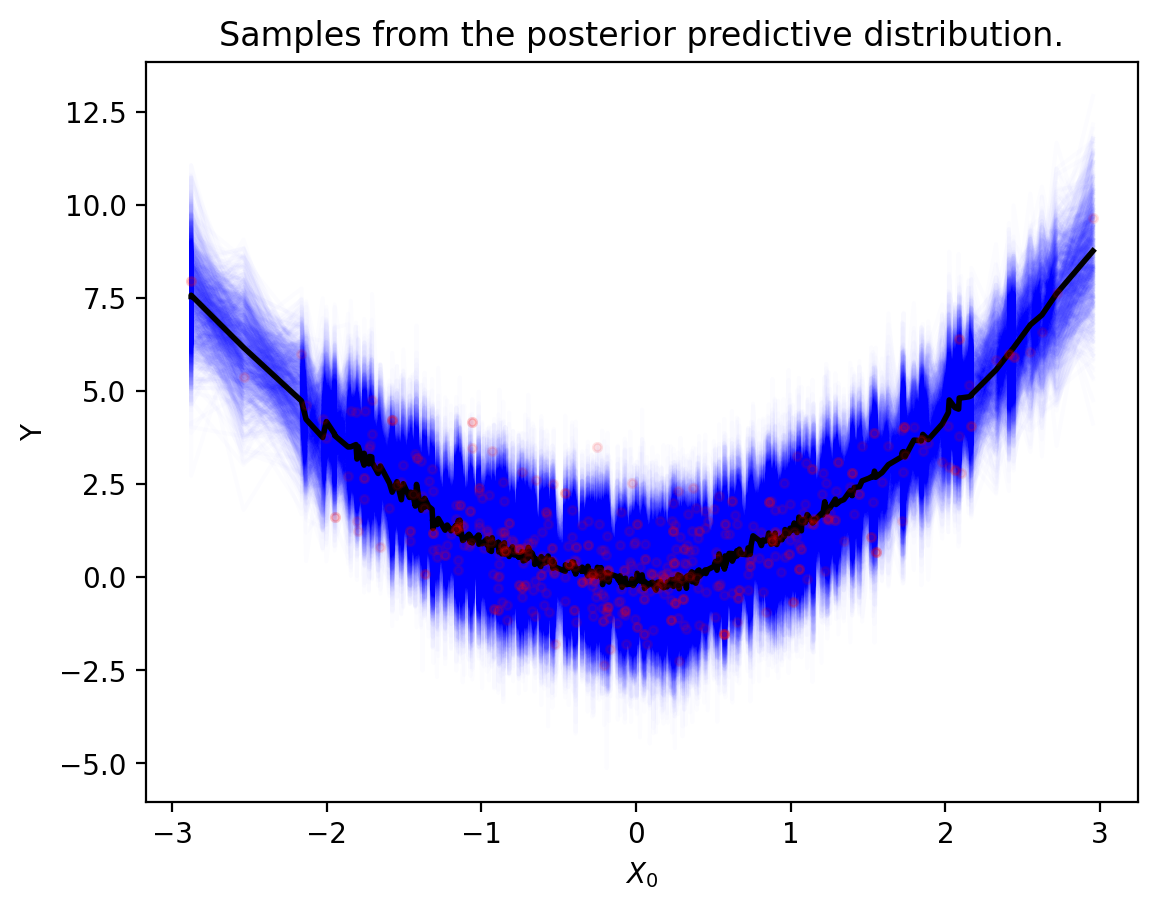

In [25]:
df = pd.DataFrame(predictions[:1000,:].T, index=X_test[:,0])
df.sort_index(inplace=True)
df.plot(legend=False, alpha=0.01, c='b')
plt.plot(X_test[:,0], mean_prediction, 'black', ls='solid', lw=2.0)
plt.plot(X_test[:,0], Y_test.squeeze(), '.', alpha=0.1, c='r')
plt.xlabel("$X_0$")
plt.ylabel("Y")
plt.title("Samples from the posterior predictive distribution.");

# Conclusion

Letting the model turn-off input-layer weights by putting an Inverse-Gamma prior on their variance significantly improves generalization.

In [26]:
 #hide
! pip install watermark

In [27]:
#hide input
%load_ext watermark
%watermark -v -m -p numpy,pandas,scipy,theano,pymc3,matplotlib,torch,numpyro

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.4
scipy 1.4.1
theano 1.0.5
pymc3 3.9.3
matplotlib 3.2.2
torch 1.7.0+cu101
numpyro 0.4.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
